# Training: Curriculum

#### 1) Train on various close-to-terminal standard situations
#### 2) Train on self-play episodes of the champion
#### 3) Avoid frustrating the freshling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random

import numpy as np
import tensorflow as tf

from aegomoku.trainer import Trainer, create_curriculum, TERMINAL_OPPORTUNITY, TERMINAL_THREAT, ENDGAME, ALL_GAMEPLAY
from aegomoku.utils import analyse_example

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BOARD_SIZE = 19

---

# Read curriculum game data

### Pickle files
Pickle files contain only single representatives of the 8 symmetries and the board positions are represented by the list of integers for the stones instead of the canonical N x X x 3 representation

In [4]:
from pathlib import Path

DATA_DIR='workspace/Project-Ellie/DATA'
PHASE = '0'
HOST = os.uname()[1]
SELFPLAY_DIR = Path(Path.home()) / DATA_DIR / 'selfplay' / PHASE
print(SELFPLAY_DIR)
all_0 = list(SELFPLAY_DIR.rglob("*.pickle"))
all_0

/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/0


In [24]:
curriculum = create_curriculum(all_0, 512, ALL_GAMEPLAY)

Preparing course: All Gameplay


100%|██████████| 57/57 [03:57<00:00,  4.17s/it]


Prepared course: All Gameplay: 580904 examples



## Terminal Opportunities

In [8]:
curriculum

{'TERMINAL_OPPORTUNITY': {'title': 'Terminal Opportunities',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_opportunity(_s, _p, v)>},
 'TERMINAL_THREAT': {'title': 'Terminal Threats',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_threat(_s, _p, v)>},
 'ENDGAME': {'title': 'General Endgame',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_endgame(_s, _p, v)>},
 'ALL_GAMEPLAY': {'title': 'All Gameplay',
  'filter': None,
  'num_examples': 580904,
  'dataset': <BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
  'data_dir': '/tmp/tmp_jbc7phe'}}

In [23]:
ds = curriculum[ALL_GAMEPLAY].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7, policy_cutoff=.001)
else:
    print("Course not available")

Course not available


In [15]:
ds = curriculum[TERMINAL_THREAT].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7.5, policy_cutoff=.001)
else:
    print("Course not available")

Course not available


In [16]:
ds = curriculum[ENDGAME].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7.5, policy_cutoff=.001)
else:
    print("Course not available")

Course not available


## General Gameplay

In [8]:
ds = curriculum[ENDGAME]['dataset']
i = iter(ds)

Next to play: WHITE
Value from WHITE's point of view: 0.9071542620658875


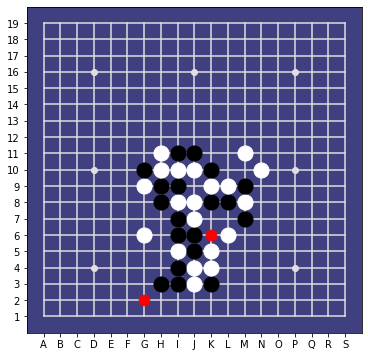

In [15]:
s, p, v = next(i)
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(example, disp_width=6, policy_cutoff=.001)


---


## Choose a model to start with


#### A freshman

In [18]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=512, num_blocks=12)
model.compile()
model.summary()

Model: "gomoku_resnet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 21, 21, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 512)  186368      ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 21, 21, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                    

#### Clone the current champion

In [19]:
model_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'models' / '0_c2s.model'
#model = tf.keras.models.load_model(model_file)

In [20]:
trainer = Trainer(model)

### You may want a warmup?

In [22]:
ds = curriculum[ENDGAME].get('dataset')
if ds is not None:
    trainer.train(ds, epochs_per_train=100, report_every=1, v_weight=2.0)
    model.save('models/from_endgame.model')
else:
    print("No warm-up today...;-)")

Epoch: 1, Training: p: 1.674161, v: 0.779066 - elapsed: 51.431s
Epoch: 2, Training: p: 1.633551, v: 0.777087 - elapsed: 25.353s
Epoch: 3, Training: p: 1.608907, v: 0.7738516 - elapsed: 25.323s
Epoch: 4, Training: p: 1.592402, v: 0.7684748 - elapsed: 25.298s
Epoch: 5, Training: p: 1.567381, v: 0.7636222 - elapsed: 25.29s
Epoch: 6, Training: p: 1.546704, v: 0.7510711 - elapsed: 25.274s
Epoch: 7, Training: p: 1.52807, v: 0.734526 - elapsed: 25.283s
Epoch: 8, Training: p: 1.51115, v: 0.7139944 - elapsed: 25.276s
Epoch: 9, Training: p: 1.495652, v: 0.6924551 - elapsed: 25.266s
Epoch: 10, Training: p: 1.48088, v: 0.6692465 - elapsed: 25.257s


KeyboardInterrupt: 

## All game play
This will last for a couple of hours

In [26]:
ds = curriculum[ALL_GAMEPLAY]['dataset']

In [27]:
trainer.train(ds, epochs_per_train=200, report_every=1, v_weight=2.0)

Epoch: 1, Training: p: 2.018402, v: 0.4402309 - elapsed: 324.73s
Epoch: 2, Training: p: 2.142501, v: 0.3803659 - elapsed: 161.37s
Epoch: 3, Training: p: 2.228122, v: 0.3353244 - elapsed: 161.66s
Epoch: 4, Training: p: 2.290237, v: 0.3002135 - elapsed: 161.82s
Epoch: 5, Training: p: 2.336817, v: 0.2720427 - elapsed: 161.81s
Epoch: 6, Training: p: 2.372714, v: 0.2489896 - elapsed: 161.89s
Epoch: 7, Training: p: 2.401079, v: 0.2297971 - elapsed: 161.92s
Epoch: 8, Training: p: 2.423814, v: 0.2135315 - elapsed: 161.95s
Epoch: 9, Training: p: 2.442257, v: 0.1995299 - elapsed: 162.04s
Epoch: 10, Training: p: 2.457495, v: 0.187379 - elapsed: 162.12s
Epoch: 11, Training: p: 2.470124, v: 0.1767089 - elapsed: 162.09s
Epoch: 12, Training: p: 2.480683, v: 0.1672432 - elapsed: 162.12s
Epoch: 13, Training: p: 2.4897, v: 0.1588233 - elapsed: 162.25s
Epoch: 14, Training: p: 2.497398, v: 0.1512443 - elapsed: 162.27s
Epoch: 15, Training: p: 2.503972, v: 0.1443759 - elapsed: 162.38s
Epoch: 16, Training: p

KeyboardInterrupt: 

In [28]:
MODEL_DIR = Path(Path.home()) / DATA_DIR / 'models'
MODEL_DIR

PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/models')

In [29]:
model.save('models/0_c2s.model')

INFO:tensorflow:Assets written to: models/0_c2s.model/assets


INFO:tensorflow:Assets written to: models/0_c2s.model/assets


In [30]:
model.save(MODEL_DIR / "0_c2s.model")

INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/0_c2s.model/assets


INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/0_c2s.model/assets


## Compare original and learned policy on the training set

In [31]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

Next to play: BLACK
Value from BLACK's point of view: -0.2131725400686264
Next to play: BLACK
Value from BLACK's point of view: -0.18323957920074463


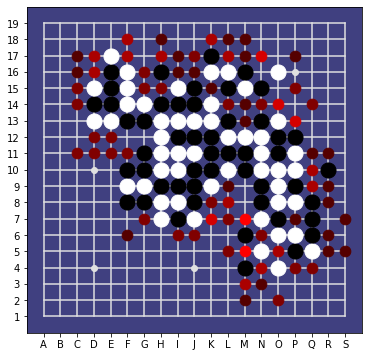

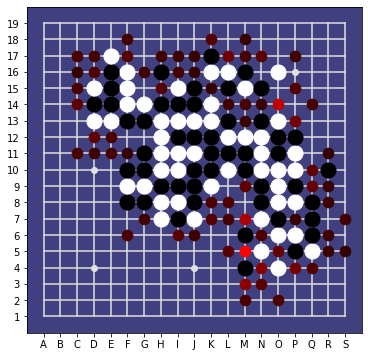

In [53]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=6)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=6, policy_cutoff=50)

## Validate on unseen data

In [67]:
SELFPLAY_DIR = Path(Path.home()) / DATA_DIR / 'selfplay_old' / '3.2' / 'tensorbook'
vali_data = list(SELFPLAY_DIR.rglob("*.pickle"))
from aegomoku.game_data import read_training_data
examples, games = read_training_data(vali_data[0])
print(vali_data[0])

/home/wgiersche/workspace/Project-Ellie/DATA/selfplay_old/3.2/tensorbook/00003.pickle


6092
Original Policy from example file
Next to play: BLACK
Value from BLACK's point of view: 0.20371011749448442
The currently trained policy
Next to play: BLACK
Value from BLACK's point of view: 0.19875596463680267


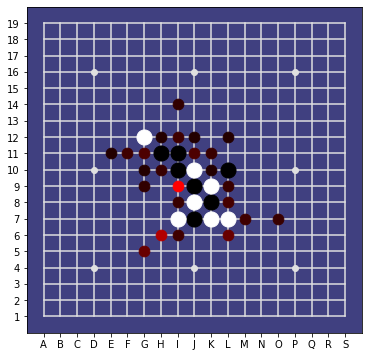

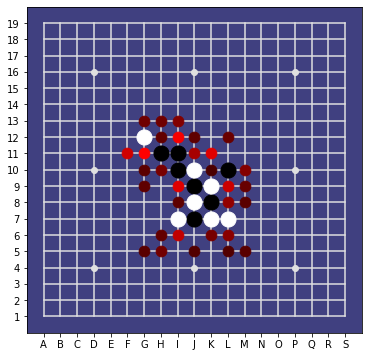

In [80]:
import random
from aegomoku.advice import PolicyAdviser
from aegomoku.interfaces import PolicyParams

n = random.randint(0, len(examples))
#n = 4688
print(n)
example = examples[n]
print("Original Policy from example file")
analyse_example(example, policy_cutoff=.01, disp_width=6)

print("The currently trained policy")
policy_params = PolicyParams(BOARD_SIZE, model_file_name=None, advice_cutoff=0.01)
adviser = PolicyAdviser(model, policy_params)
s, _, _ = example
p, v = adviser.evaluate(s)
analyse_example((s, p, v), policy_cutoff=.01, disp_width=6)